In [1]:
import pandas as pd
import cluj_tools as ct

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

### Get Rosters

In [2]:
matchup_end_date, matchupPeriod = ct.matchup_end_date()

Matchup end date is 2020-02-09
Matchup period is 16


In [3]:
rosters = ct.get_rosters(matchupPeriod)

### Get Boxscore data to calculate octys

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
sql = """
    SELECT * FROM boxscores b
    LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
    WHERE b.season_year = '2019-2020' AND b.season_type = 'regular'
"""

In [6]:
boxscores = pd.read_sql(sql, engine)
boxscores['ft_pct'] = boxscores.ftm / boxscores.fta
boxscores['fg_pct'] = boxscores.fgm / boxscores.fga

In [7]:
boxscores.loc[boxscores.espn_name.isnull(),'espn_name'] = boxscores.loc[boxscores.espn_name.isnull(),'name']

In [8]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(412, 21)

In [9]:
octy_counts = pd.DataFrame(octys.espn_name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'espn_name':'octy_count', 'index':'espn_name'}, inplace=True)

In [10]:
octy_counts.head()

,espn_name,octy_count
0,Anthony Davis,14
1,James Harden,11
2,Kawhi Leonard,9
3,Brandon Ingram,8
4,Joel Embiid,8


In [11]:
octys_games = pd.DataFrame(boxscores.groupby('espn_name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [12]:
merged = octy_counts.merge(octys_games, on='espn_name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)
merged.shape

(178, 4)

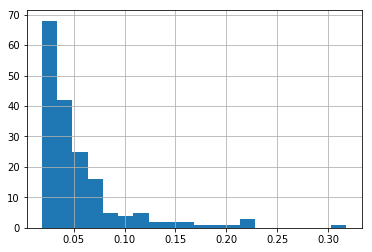

In [13]:
merged.octy_pct.hist(bins=20)

In [14]:
merged.head(30)

,espn_name,octy_count,game_count,octy_pct
0,Anthony Davis,14,44,0.318182
2,Kawhi Leonard,9,40,0.225000
1,James Harden,11,49,0.224490
4,Joel Embiid,8,37,0.216216
21,Kyrie Irving,4,20,0.200000
15,John Collins,5,27,0.185185
3,Brandon Ingram,8,47,0.170213
5,Pascal Siakam,7,42,0.166667
10,Josh Richardson,6,39,0.153846
6,Jayson Tatum,7,47,0.148936


In [15]:
rosters_merge = merged.merge(rosters, left_on='espn_name', right_on='fullName', how='left')
rosters_merge.shape

(178, 6)

In [16]:
rosters_merge.groupby('teamId')['octy_pct'].mean().sort_values()

teamId
1.0     0.043327
12.0    0.052029
2.0     0.054321
11.0    0.057485
3.0     0.059544
9.0     0.059592
6.0     0.067172
10.0    0.067444
8.0     0.071878
7.0     0.077886
5.0     0.078614
4.0     0.096583
Name: octy_pct, dtype: float64

In [17]:
rosters_merge.groupby('teamId')['octy_count'].sum()

teamId
1.0     20
2.0     18
3.0     27
4.0     45
5.0     35
6.0     24
7.0     31
8.0     24
9.0     23
10.0    34
11.0    24
12.0    20
Name: octy_count, dtype: int64

In [18]:
rosters_merge.loc[rosters_merge.teamId == 10]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
8,Josh Richardson,6,39,0.153846,Josh Richardson,10.0
11,Nikola Jokic,7,53,0.132075,Nikola Jokic,10.0
16,Myles Turner,5,43,0.116279,Myles Turner,10.0
27,Miles Bridges,4,52,0.076923,Miles Bridges,10.0
75,Derrick Rose,2,44,0.045455,Derrick Rose,10.0
78,Jeff Teague,2,45,0.044444,Jeff Teague,10.0
82,Matisse Thybulle,2,45,0.044444,Matisse Thybulle,10.0
85,Giannis Antetokounmpo,2,48,0.041667,Giannis Antetokounmpo,10.0
106,Justin Holiday,2,53,0.037736,Justin Holiday,10.0
116,Elfrid Payton,1,34,0.029412,Elfrid Payton,10.0


In [20]:
# should only be players on waiver wire
rosters_merge.loc[rosters_merge.fullName.isnull()].sort_values('octy_pct', ascending=False).head(20)

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
19,Kadeem Allen,1,10,0.100000,NaN,NaN
21,Jonathan Isaac,3,32,0.093750,NaN,NaN
23,Justise Winslow,1,11,0.090909,NaN,NaN
28,PJ Dozier,1,13,0.076923,NaN,NaN
30,Mikal Bridges,4,53,0.075472,NaN,NaN
43,Jabari Parker,2,32,0.062500,NaN,NaN
47,Josh Okogie,3,49,0.061224,NaN,NaN
56,Maxi Kleber,3,52,0.057692,NaN,NaN
60,Damion Lee,2,37,0.054054,NaN,NaN
61,Derrick Jones Jr,2,37,0.054054,NaN,NaN
